In [14]:
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

def read_ground_truth(xml_file, classes):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_info = {}

    for track in root.findall('./track'):
        label = track.attrib['label']
        if label in classes:
            for box in track.findall('box'):
                frame = int(box.attrib['frame'])
                xtl = float(box.attrib['xtl'])
                ytl = float(box.attrib['ytl'])
                xbr = float(box.attrib['xbr'])
                ybr = float(box.attrib['ybr'])
                
                bbox_info.setdefault(frame, []).append([
                    xtl, ytl, xbr, ybr
                ])
        
    return bbox_info

def draw_bbox(path, frame_list, frameNumber, bboxGT, bboxPred, draw = True):
    frame = cv2.imread(path + frame_list[frameNumber], cv2.IMREAD_COLOR)
    
    for bbox in bboxGT:
        xtl, ytl, xbr, ybr = bbox
        xtl, ytl, xbr, ybr = int(xtl), int(ytl), int(xbr), int(ybr)
        cv2.rectangle(frame, (xtl, ytl), (xbr, ybr), (0, 255, 0), 2)
    
    for bbox in bboxPred:
        xtl, ytl, xbr, ybr = bbox
        xtl, ytl, xbr, ybr = int(xtl), int(ytl), int(xbr), int(ybr)
        cv2.rectangle(frame, (xtl, ytl), (xbr, ybr), (0, 0, 255), 2)
    
    if draw:
        plt.imshow(frame[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [15]:
xml_file = 'ai_challenge_s03_c010-full_annotation.xml'
classes = ['car'] # The other class is bike
bbox_info = read_ground_truth(xml_file, classes)

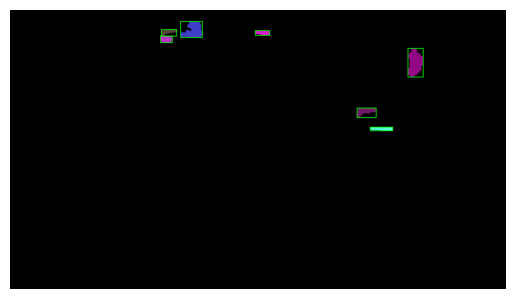

In [20]:
framesPath = 'framesResult/'

frames = os.listdir(framesPath)

frame_number = 1000

image = cv2.imread(framesPath + frames[frame_number], cv2.IMREAD_COLOR)

if len(image.shape) > 2:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

min_area_threshold = 200

filtred_components = np.zeros_like(gray_image)

for i in range(1, num_labels):  # Exclude background label which is 0
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_area_threshold:
        mask = labels == i
        color = 255  # Generate a random color
        filtred_components[mask] = color

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtred_components, connectivity=8)

_, binary_image = cv2.threshold(filtred_components, 127, 255, cv2.THRESH_BINARY)

binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)))

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

output_image = np.zeros_like(image)

bounding_boxes = []

for i in range(1, num_labels):  # Exclude background label which is 0
    area = stats[i, cv2.CC_STAT_AREA]
    mask = labels == i
    color = np.random.randint(0, 255, size=3)  # Generate a random color
    output_image[mask] = color

    x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

    bounding_boxes.append((x, y, w, h))

merged_boxes = []
for box in bounding_boxes:
    x, y, w, h = box
    merged = False
    for index, (merged_x, merged_y, merged_w, merged_h) in enumerate(merged_boxes):
        if x >= merged_x and y >= merged_y and x + w <= merged_x + merged_w and y + h <= merged_y + merged_h:
            merged_boxes[index] = (x, y, w, h)
            merged = True
            break
        elif x <= merged_x and y <= merged_y and x + w >= merged_x + merged_w and y + h >= merged_y + merged_h:
            merged_boxes[index] = (merged_x, merged_y, merged_w, merged_h)
            merged = True
            break
    if not merged:
        merged_boxes.append((x, y, w, h))


for (x, y, w, h) in merged_boxes:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.imshow(output_image)
plt.axis('off')
plt.show()

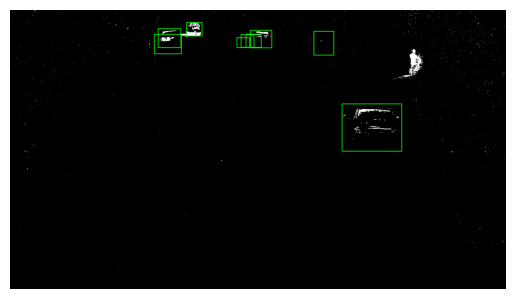

In [21]:
draw_bbox(framesPath, frames, frame_number, bbox_info[frame_number], [])